# All Data EDA

Description of data cleaning before this file:

1. Load, combine, clean credit rating datasets to get unique ratings, company/tickers, and rating issue dates (unique key is credit rating, rating agency, and issuance date). Limit to S&P ratings from 2010-2016.
2. Load and clean dataset of earnings call transcripts, dates, year + quarter of statement releases, companies (unique key is company by earnings call date).
3. Load and clean tabular financial statement datasets (unique key is company, year, quarter).
4. Load and clean company sector dataset (unique key is company).
5. Use earnings call dates to transform dataset of credit ratings so there is one rating at each fixed quarter date (1/1, 4/1, 7/1, 10/1) for each year. The key assumption is that a rating stays the same until a new rating is issued.
6. Inner join earnings call data with credit rating data, retrieving the most recent earnings call. Use year and quarter from earnings calls to inner join with financial statement data. This produces the `all_data_fixed_quarter` dataset.

GitHub copilot suggestions were used for plotting and low-level syntax.

## Setup - Sample Path and Packages

In [1]:
# Flag for if you are running this on the sample dataset
# Sample comprises 100 earnings calls (transcripts included)
# Full data comprises ??? earnings calls (transcripts included)
sample = False
# Modify this path as needed to run on your machine
sample_path = r'~\Box\STAT 222 Capstone\Intermediate Data\All_Data\all_data_fixed_quarter_dates_sample.csv'

In [2]:
# Packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from stattotex import *

In [3]:
# Set output folder
output_folder = '../../../Output/All Data EDA/Tabular EDA/'

## Data Load and Basic Stats

In [4]:
# Load in sample csv, or full parquet file
# Use sample or full data path
if sample:
    df = pd.read_csv(sample_path)
else:
    # Limit to items in the finalized dataset
    # list of files in '../../../Data/All_Data/All_Data_with_NLP_Features'
    import os
    file_list = [f for f in os.listdir(r'../../../Data/All_Data/All_Data_with_NLP_Features') if f.endswith('.parquet')]
    # read in all parquet files
    df = pd.concat([pd.read_parquet(r'../../../Data/All_Data/All_Data_with_NLP_Features/' + f) for f in file_list])
df

,ticker,fixed_quarter_date,earnings_call_date,Rating,rating_date,Rating Rank AAA is 10,Next Rating,Next Rating Date,Previous Rating,Previous Rating Date,...,Weak,Active,Passive,Ovrst,Undrst,PN,SW,AP,OU,TONE1
0,AAPL,2014-10-01,2014-07-22,AA,2014-05-27,9,AA,2015-02-18,AAA,2014-04-24,...,42.0,495.0,186.0,364.0,131.0,5.518519,15.261905,2.661290,2.778626,3.188264
1,AAPL,2015-01-01,2014-10-20,AA,2014-05-27,9,AA,2015-02-18,AAA,2014-04-24,...,46.0,656.0,199.0,465.0,152.0,5.348485,15.934783,3.296482,3.059211,3.681858
2,AAPL,2015-04-01,2015-01-27,AA,2015-02-18,9,AA,2015-05-28,AA,2014-05-27,...,88.0,591.0,208.0,468.0,151.0,3.927711,8.113636,2.841346,3.099338,1.307366
3,AAPL,2015-07-01,2015-04-27,AA,2015-06-02,9,AA,2015-08-25,AA,2015-05-28,...,70.0,565.0,214.0,415.0,135.0,5.250000,9.142857,2.640187,3.074074,2.025933
4,AAPL,2015-10-01,2015-07-21,AA,2015-08-25,9,AA,2016-05-20,AA,2015-06-02,...,70.0,565.0,219.0,449.0,148.0,4.209877,10.442857,2.579909,3.033784,1.815531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,ZTS,2015-10-01,2015-08-04,BBB,2015-01-30,7,BBB,2015-11-03,BBB,2014-01-31,...,52.0,623.0,214.0,298.0,148.0,3.611650,15.634615,2.911215,2.013514,1.744657
469,ZTS,2016-01-01,2015-11-03,BBB,2015-11-03,7,BBB,2016-01-22,BBB,2015-01-30,...,79.0,737.0,264.0,395.0,222.0,3.766917,15.848101,2.791667,1.779279,1.596294
470,ZTS,2016-04-01,2016-02-16,BBB,2016-01-22,7,BBB,2016-12-23,BBB,2015-11-03,...,73.0,840.0,287.0,469.0,217.0,3.565517,17.506849,2.926829,2.161290,2.287146
471,ZTS,2016-07-01,2016-05-04,BBB,2016-01-22,7,BBB,2016-12-23,BBB,2015-11-03,...,68.0,765.0,253.0,449.0,215.0,3.572650,15.235294,3.023715,2.088372,1.739992


In [5]:
## summary of the raw data 

# Summarize all numeric columns
# use describe method, transpose, and print all rows
# round to two decimal places, no scientific notation, commas for thousands
pd.options.display.float_format = '{:,.2f}'.format
# pandas setting to display all rows
pd.set_option('display.max_rows', None)
df.describe().T

,count,mean,min,25%,50%,75%,max,std
earnings_call_date,4724,2014-09-20 19:00:03.048264192,2010-10-28 00:00:00,2013-10-15 00:00:00,2014-11-04 00:00:00,2015-10-31 06:00:00,2016-09-29 00:00:00,NaN
Rating Rank AAA is 10,"4,724.00",6.71,1.00,6.00,7.00,8.00,10.00,1.29
credit_rating_year,"4,724.00","2,013.57","2,010.00","2,012.00","2,014.00","2,015.00","2,016.00",1.43
days_since_call_on_fixed_quarter,"4,724.00",58.21,0.00,55.00,61.00,66.00,91.00,13.30
days_since_rating,"4,724.00",293.07,0.00,73.00,182.00,341.00,"1,930.00",331.48
for_quarter,"4,724.00",2.45,1.00,1.00,2.00,3.00,4.00,1.11
for_year,"4,724.00","2,014.09","2,010.00","2,013.00","2,014.00","2,015.00","2,016.00",1.38
cashAndCashEquivalents,"4,724.00","852,349,405.25",0.00,"87,178,000.00","303,118,000.00","917,516,250.00","9,204,000,000.00","1,382,415,295.39"
shortTermInvestments,"4,724.00","171,674,306.11","-515,000.00",0.00,0.00,"14,702,000.00","6,178,000,000.00","570,578,944.19"
cashAndShortTermInvestments,"4,724.00","1,029,007,733.36",0.00,"86,150,750.00","328,148,000.00","1,063,250,000.00","15,601,000,000.00","1,875,370,693.02"


In [6]:
# Revert to default settings
pd.reset_option('display.float_format')
pd.reset_option('display.max_rows')

In [7]:
# Check data is unique on ticker by fixed_quarter_date
df['ticker_fixed_quarter_date'] = df['ticker'] + '_' + df['fixed_quarter_date'].astype(str)
df['ticker_fixed_quarter_date'].value_counts().max()

1

In [8]:
# Number of unique firms (identified by ticker)
df['ticker'].nunique()

# Save number of quarters and companies
stattotex(len(df), 'numQuarters', output_folder + 'num_quarters_and_companies.tex')
stattotex(df['ticker'].nunique(), 'numCompanies', output_folder + 'num_quarters_and_companies.tex', clear_preexisting=False)

## Sector

In [9]:
# How often is Sector variable missing?
print('Share of missing values for Sector:', df['Sector'].isna().mean())

Share of missing values for Sector: 0.0


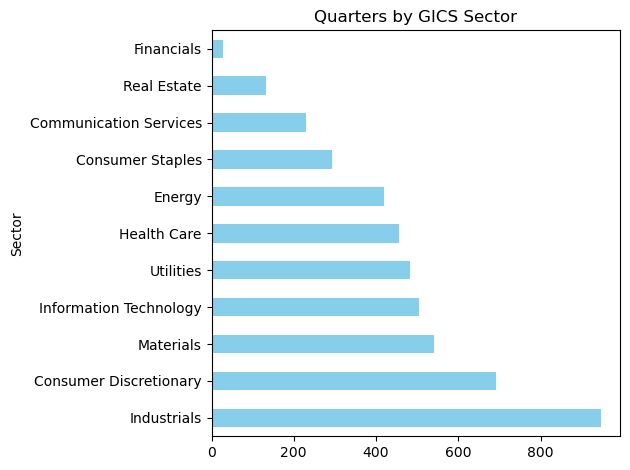

In [10]:
# Distribution of industry sectors
# variable sector
# Title: Calls in Each Industry Sector
df['Sector'].value_counts().plot(kind = 'barh', color = 'skyblue')
plt.title('Quarters by GICS Sector')
# set to tight layout
plt.tight_layout()
plt.savefig(output_folder + 'all_data_fixed_quarter_dates_sector_distribution.png')
plt.show()

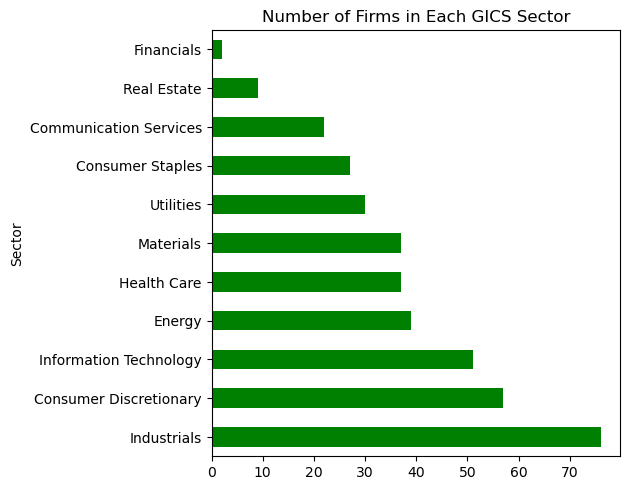

In [11]:
# Number of firms in each industry sector
# Title: Number of Firms in Each Industry Sector
# Unique ticker by sector, sort by number of firms
df.groupby('Sector')['ticker'].nunique().sort_values(ascending=False).plot(kind = 'barh', color = 'green')
# set to tight layout
plt.tight_layout()
# save version with no title
plt.savefig(output_folder + 'all_data_fixed_quarter_dates_firms_by_sector_no_title.png')
plt.title('Number of Firms in Each GICS Sector')
plt.savefig(output_folder + 'all_data_fixed_quarter_dates_firms_by_sector.png')
plt.show()

## Quarter Counts

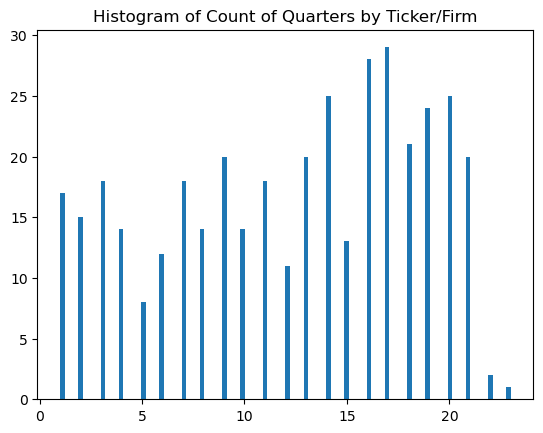

In [12]:
plt.hist(df['ticker'].value_counts(), bins = 100)
plt.title('Histogram of Count of Quarters by Ticker/Firm')
plt.savefig(output_folder + 'all_data_fixed_quarter_dates_obs_by_ticker.png')
plt.show()

## Call Stats

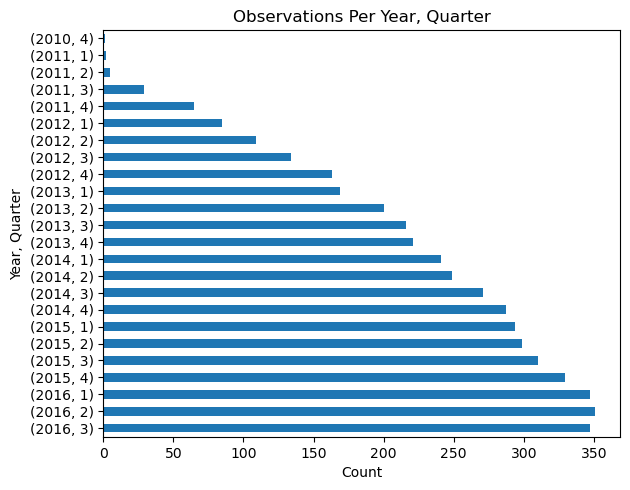

In [13]:
# Distribution of earnings_call_date year and quarter
# Create call_year and call_quarter columns after converting earnings_call_date to datetime
df['call_year'] = pd.to_datetime(df['earnings_call_date']).dt.year
df['call_quarter'] = pd.to_datetime(df['earnings_call_date']).dt.quarter
# Group by year and quarter
data_grouped = df.groupby([df.call_year, df.call_quarter]).size().sort_index(ascending=False)
# Plot horizontal bar chart
# 2010 at the top
data_grouped.plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Year, Quarter')
plt.tight_layout()
# Save version with no title
plt.savefig(output_folder + 'all_data_fixed_quarter_dates_obs_by_year_quarter_no_title.png')
plt.title('Observations Per Year, Quarter')
plt.savefig(output_folder + 'all_data_fixed_quarter_dates_obs_by_year_quarter.png')
plt.show()


See All Data - Analyze Dropout for an investigation of company dropout.

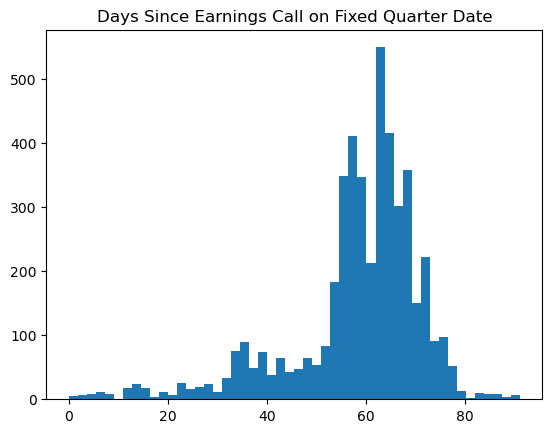

In [14]:
# Histogram of days_since_call
#credit_ratings_on_fixed_quarter_dates_with_earnings_call_date['days_since_call'].plot.hist(bins=50)
plt.hist(df['days_since_call_on_fixed_quarter'], bins=50)
plt.title('Days Since Earnings Call on Fixed Quarter Date')
plt.savefig(output_folder + 'fixed_quarter_days_since_call_all_data.png')
plt.show()

## Ratings

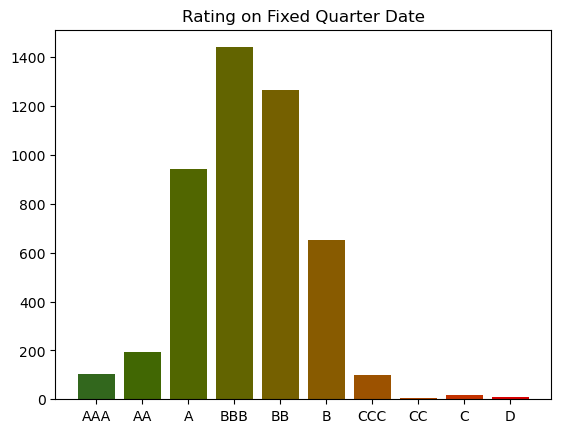

In [15]:
# Distribution of Rating and rating_on_next_earnings_call_date

# Colored with gradient and ordered

# Colors AAA through D
# Used https://colordesigner.io/gradient-generator#google_vignette
# Assign hex codes from green to red
#32671d
#416703
#516600
#626400
#756000
#885b00
#9c5200
#af4500
#c33200
#d60000
hex_code_mapper = {'AAA': '#32671d', 'AA': '#416703', 'A': '#516600', 'BBB': '#626400', 'BB': '#756000', 'B': '#885b00', 'CCC': '#9c5200', 'CC': '#af4500', 'C': '#c33200', 'D': '#d60000'}

# Ordering of bars - keys from hex_code_mapper
bar_order = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC', 'C', 'D']
# Assign values of Rating to this ordering
df['Rating'] = pd.Categorical(df['Rating'], categories=bar_order, ordered=True)

# Create plot
# Save to "../Output/Distribution of Ratings.png"
plt.bar(df['Rating'].value_counts().sort_index().index, df['Rating'].value_counts().sort_index(), color=[hex_code_mapper[i] for i in bar_order])
# Save version with no title
plt.savefig(output_folder + 'Distribution of Rating Issuances_no_title.png')
plt.title('Rating on Fixed Quarter Date')
plt.savefig(output_folder + 'Distribution of Rating Issuances.png')
plt.show()

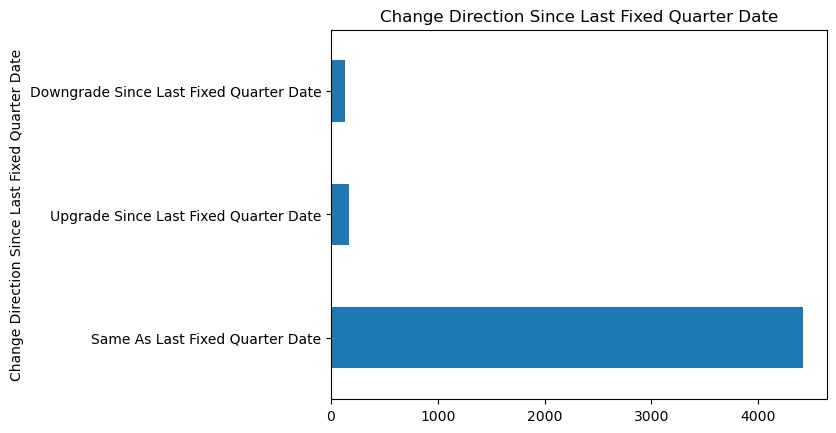

Change Direction Since Last Fixed Quarter Date
Same As Last Fixed Quarter Date            4421
Upgrade Since Last Fixed Quarter Date       172
Downgrade Since Last Fixed Quarter Date     131
Name: count, dtype: int64


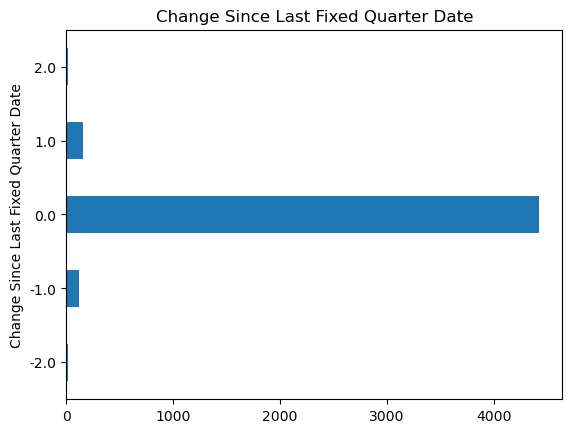

Change Since Last Fixed Quarter Date
-2.0      15
-1.0     116
 0.0    4421
 1.0     154
 2.0      18
Name: count, dtype: int64


In [16]:
df['Change Direction Since Last Fixed Quarter Date'].value_counts().plot(kind='barh')
plt.title('Change Direction Since Last Fixed Quarter Date')
plt.show()
print(df['Change Direction Since Last Fixed Quarter Date'].value_counts())

df['Change Since Last Fixed Quarter Date'].value_counts().sort_index().plot(kind='barh')
plt.title('Change Since Last Fixed Quarter Date')
plt.show()
print(df['Change Since Last Fixed Quarter Date'].value_counts().sort_index())


In [17]:
# Share of ratings that are changes
print('Share of ratings that are changes:', len(df[df['Change Direction Since Last Fixed Quarter Date'] != 'Same As Last Fixed Quarter Date']) / len(df))

Share of ratings that are changes: 0.06414055884843353


In [18]:
# Value counts of variable Investment_Grade
df['Investment_Grade'].value_counts()

Investment_Grade
True     2678
False    2046
Name: count, dtype: int64

## Financial Statement Data

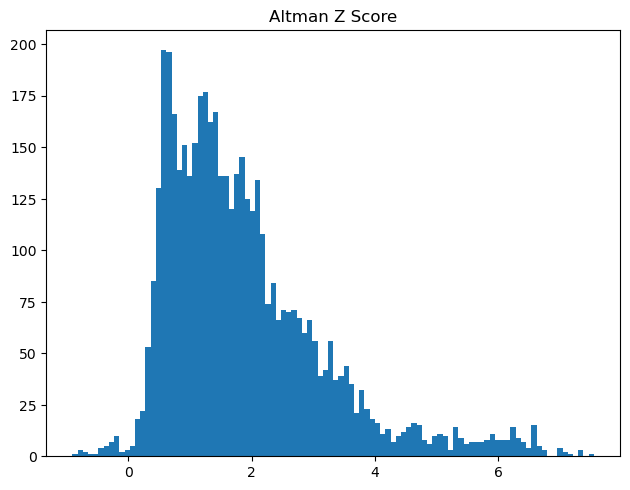

In [19]:
# Plot Altman_Z histogram
plt.hist(df['Altman_Z'], bins=100)
plt.tight_layout()
plt.savefig(output_folder + 'altman_z_score_all_data_no_title.png')
plt.title('Altman Z Score')
plt.savefig(output_folder + 'altman_z_score_all_data.png')
plt.show()

C:\Users\ijyli\AppData\Local\Temp\ipykernel_6184\2139239575.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_assets_by_rating = df.groupby('Rating')['totalDebt'].mean()


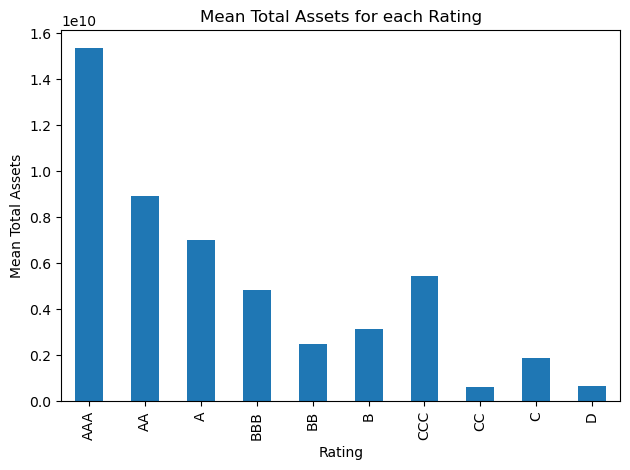

In [20]:
# Calculate the mean of "totalAssets" for each kind of "Rating"
mean_assets_by_rating = df.groupby('Rating')['totalDebt'].mean()

# Plotting
mean_assets_by_rating.plot(kind='bar')
plt.title('Mean Total Assets for each Rating')
plt.xlabel('Rating')
plt.ylabel('Mean Total Assets')
plt.tight_layout()
plt.savefig(output_folder + 'mean_total_assets_by_rating.png')
plt.show()

C:\Users\ijyli\AppData\Local\Temp\ipykernel_6184\796684613.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_gross_profit_by_rating = df.groupby('Rating')["grossProfitRatio"].mean()


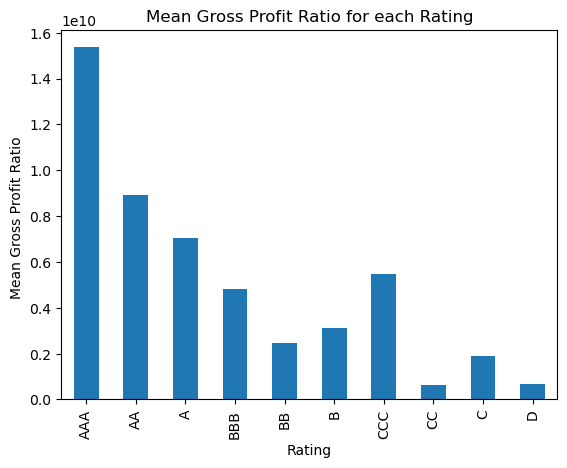

In [21]:
# Calculate the mean of "grossProfitRatio" for each kind of "Rating"
mean_gross_profit_by_rating = df.groupby('Rating')["grossProfitRatio"].mean()

# Plotting
mean_assets_by_rating.plot(kind='bar')
plt.title('Mean Gross Profit Ratio for each Rating')
plt.xlabel('Rating')
plt.ylabel('Mean Gross Profit Ratio ')
plt.show()

We can see the relationship between rating and total assets; rating and gross profit ratio. High ratings like AAA will have high mean total assets and high mean gross profit ratio.

In [22]:
# Checking normalized average fianncial value to compare to the graph NN paper's table A.1
# Empty dataframe to store item, count, and percent_of_total_assets
table_a1_replication = pd.DataFrame(columns=['Item', 'Count', 'Percent_of_Total_Assets'])
# Compute average values of: totalAssets, currentLiabilities, totalLiabilities, totalEquity, retainedEarnings, currentAssets, netSales (revenue stand-in), EBIT (ebitda minus depreciation, etc),  market value of equity (commonStock + preferredStock stand-in), workingCapital, and Altman_Z
# Mean of total assets, removing missing and infinite values
total_assets_mean = df['totalAssets'].replace([np.inf, -np.inf], np.nan).dropna().mean()
# Loop over each variable
# Drop missing or infinite values
# Compute count and mean
for variable in ['totalAssets', 'totalCurrentLiabilities', 'totalLiabilities', 'totalEquity', 'retainedEarnings', 'totalCurrentAssets', 'revenue', 'EBIT', 'marketCap', 'workingCapital']:
    var_count = df[variable].replace([np.inf, -np.inf], np.nan).dropna().count()
    var_mean = df[variable].replace([np.inf, -np.inf], np.nan).dropna().mean()
    table_a1_replication = pd.concat([table_a1_replication, pd.DataFrame({'Item': variable, 'Count': var_count, 'Percent_of_Total_Assets': 100*var_mean/total_assets_mean}, index=[0])])

table_a1_replication

C:\Users\ijyli\AppData\Local\Temp\ipykernel_6184\949429418.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table_a1_replication = pd.concat([table_a1_replication, pd.DataFrame({'Item': variable, 'Count': var_count, 'Percent_of_Total_Assets': 100*var_mean/total_assets_mean}, index=[0])])


,Item,Count,Percent_of_Total_Assets
0,totalAssets,4724,100.000000
0,totalCurrentLiabilities,4724,17.715440
0,totalLiabilities,4724,63.236043
0,totalEquity,4724,31.328788
0,retainedEarnings,4724,22.626868
0,totalCurrentAssets,4724,24.661677
0,revenue,4724,17.156209
0,EBIT,4724,1.900327
0,marketCap,4724,124.889988
0,workingCapital,4724,6.946238


In [23]:
# Average value of key ratios and altman Z
# use describe method, transpose, and print all rows
# round to two decimal places, no scientific notation, commas for thousands
pd.options.display.float_format = '{:,.2f}'.format
sum_stats_ratios = df[['Ratio_A', 'Ratio_B', 'Ratio_C', 'Ratio_D', 'Ratio_E', 'Altman_Z']].describe().T
sum_stats_ratios

,count,mean,std,min,25%,50%,75%,max
Ratio_A,"4,724.00",0.02,0.02,-0.02,0.01,0.02,0.03,0.08
Ratio_B,"4,724.00",0.21,0.15,0.04,0.10,0.18,0.27,0.70
Ratio_C,"4,724.00",1.87,1.58,0.29,0.81,1.40,2.41,8.06
Ratio_D,"4,724.00",0.13,0.15,-0.13,0.01,0.10,0.23,0.57
Ratio_E,"4,724.00",0.23,0.32,-0.74,0.00,0.21,0.41,1.01
Altman_Z,"4,724.00",1.88,1.30,-0.91,0.94,1.58,2.47,7.56
